In [ ]:
#NUMPY
#https://numpy.org/doc/stable/index.html
#https://www.w3schools.com/python/numpy_intro.asp

In [ ]:
import numpy as np
np.set_printoptions(suppress=True, precision=3)

In [ ]:
#From Winning the NBA Bracket-making an array
known_years = np.arange(1990, 2021).astype(np.int64)
known_years

In [ ]:
#Math functions
np.mean([1,4,3,2,6,4,4,3,2,6])

In [ ]:
np.var([1,3,3,6,3,2,7,5,9,1])

In [ ]:
import pyjet

In [ ]:
#PATH FINDING
#Path finding is all about finding the shortest path in a graph. This can be split in two distinct problems
#: to find a path between two nodes in a graph and to find the shortest path. We'll illustrate this through path 
#finding in a maze. 

# -----------------------------------------------------------------------------
# From Numpy to Python
# Copyright (2017) Nicolas P. Rougier - BSD license
# More information at https://github.com/rougier/numpy-book
# -----------------------------------------------------------------------------
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from scipy.ndimage import generic_filter


def build_maze(shape=(65,65), complexity=0.75, density = 0.50):
    """
    Build a maze using given complexity and density

    Parameters
    ==========

    shape : (rows,cols)
      Size of the maze

    complexity: float
      Mean length of islands (as a ratio of maze size)

    density: float
      Mean numbers of highland (as a ratio of maze surface)

    """
    
    # Only odd shapes
    shape = ((shape[0]//2)*2+1, (shape[1]//2)*2+1)

    # Adjust complexity and density relatively to maze size
    n_complexity = int(complexity*(shape[0]+shape[1]))
    n_density    = int(density*(shape[0]*shape[1]))

    # Build actual maze
    Z = np.zeros(shape, dtype=bool)

    # Fill borders
    Z[0,:] = Z[-1,:] = Z[:,0] = Z[:,-1] = 1

    # Islands starting point with a bias in favor of border
    P = np.random.normal(0, 0.5, (n_density,2))
    P = 0.5 - np.maximum(-0.5, np.minimum(P, +0.5))
    P = (P*[shape[1],shape[0]]).astype(int)
    P = 2*(P//2)
    
    # Create islands
    for i in range(n_density):

        # Test for early stop: if all starting point are busy, this means we
        # won't be able to connect any island, so we stop.
        T = Z[2:-2:2,2:-2:2]
        if T.sum() == T.size:
            break

        x, y = P[i]
        Z[y,x] = 1
        for j in range(n_complexity):
            neighbours = []
            if x > 1:
                neighbours.append([(y, x-1), (y, x-2)])
            if x < shape[1]-2:
                neighbours.append([(y, x+1), (y, x+2)])
            if y > 1:
                neighbours.append([(y-1, x), (y-2, x)])
            if y < shape[0]-2:
                neighbours.append([(y+1, x), (y+2, x)])
            if len(neighbours):
                choice = np.random.randint(len(neighbours))
                next_1, next_2 = neighbours[choice]
                if Z[next_2] == 0:
                    Z[next_1] = Z[next_2] = 1
                    y, x = next_2
            else:
                break
    return Z


# ------------------------------------------------------ find_shortest_path ---
def BellmanFord(Z, start, goal):

    # We reserve Z such that walls have value 0
    Z = 1 - Z
    
    # Build gradient array
    G = np.zeros(Z.shape)

    # Initialize gradient at the entrance with value 1
    G[start] = 1

    # Discount factor
    gamma = 0.99
    
    def diffuse(Z):
        # North, West, Center, East, South
        return max(gamma*Z[0], gamma*Z[1], Z[2], gamma*Z[3], gamma*Z[4])

    # Shortest path in best case cannot be less the Manhattan distance
    # from entrance to exit
    length = Z.shape[0]+Z.shape[1]

    # We iterate until value at exit is > 0. This requires the maze
    # to have a solution or it will be stuck in the loop.

    G_gamma = np.empty_like(G)
    while G[goal] == 0.0:
        # Slow
        # G = Z * generic_filter(G, diffuse, footprint=[[0, 1, 0],
        #                                               [1, 1, 1],
        #                                               [0, 1, 0]])

        # Fast
        np.multiply(G, gamma, out=G_gamma)
        N = G_gamma[0:-2,1:-1]
        W = G_gamma[1:-1,0:-2]
        C = G[1:-1,1:-1]
        E = G_gamma[1:-1,2:]
        S = G_gamma[2:,1:-1]
        G[1:-1,1:-1] = Z[1:-1,1:-1]*np.maximum(N,np.maximum(W,np.maximum(C,np.maximum(E,S))))
    
    # Descent gradient to find shortest path from entrance to exit
    y, x = goal
    P = []
    dirs = [(0,-1), (0,+1), (-1,0), (+1,0)]
    while (x, y) != start:
        P.append((x, y))
        neighbours = [-1, -1, -1, -1]
        if x > 0:
            neighbours[0] = G[y, x-1]
        if x < G.shape[1]-1:
            neighbours[1] = G[y, x+1]
        if y > 0:
            neighbours[2] = G[y-1, x]
        if y < G.shape[0]-1:
            neighbours[3] = G[y+1, x]
        a = np.argmax(neighbours)
        x, y  = x + dirs[a][1], y + dirs[a][0]
    P.append((x, y))
    return G, np.array(P)

def build_graph(maze):
    height, width = maze.shape
    graph = {(i, j): [] for j in range(width) for i in range(height) if not maze[i][j]}
    for row, col in graph.keys():
        if row < height - 1 and not maze[row + 1][col]:
            graph[(row, col)].append(("S", (row + 1, col)))
            graph[(row + 1, col)].append(("N", (row, col)))
        if col < width - 1 and not maze[row][col + 1]:
            graph[(row, col)].append(("E", (row, col + 1)))
            graph[(row, col + 1)].append(("W", (row, col)))
    return graph

def BreadthFirst(maze, start, goal):
    queue = deque([([start], start)])
    visited = set()
    graph = build_graph(maze)
    while queue:
        path, current = queue.popleft()
        if current == goal:
            return np.array(path)
        if current in visited:
            continue
        visited.add(current)
        for direction, neighbour in graph[current]:
            p = list(path)
            p.append(neighbour)
            queue.append((p, neighbour))
    return None


# -------------------------------------------------------------------- main ---
if __name__ == '__main__':

    Z = build_maze((41,81))
    start, goal = (1,1), (Z.shape[0]-2, Z.shape[1]-2)
    
    G, P = BellmanFord(Z, start, goal)
    X, Y = P[:,0], P[:,1]
        
    # P = BreadthFirst(Z, start, goal)
    # X, Y = P[:,1], P[:,0]
    
    # Visualization maze, gradient and shortest path
    plt.figure(figsize=(13, 13*Z.shape[0]/Z.shape[1]))
    ax = plt.subplot(1, 1, 1, frameon=False)
    ax.imshow(Z, interpolation='nearest', cmap=plt.cm.gray_r, vmin=0.0, vmax=1.0)
    cmap = plt.cm.hot
    cmap.set_under(color='k', alpha=0.0)
    ax.imshow(G, interpolation='nearest', cmap=cmap, vmin=0.01, vmax=G[start])
    ax.scatter(X[1:-1], Y[1:-1], s=60,
               lw=1, marker='o', edgecolors='k', facecolors='w')
    ax.scatter(X[[0,-1]], Y[[0,-1]], s=60,
               lw=3, marker='x', color=['w','k'])
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()
    plt.savefig("maze.png")
    plt.show()

In [ ]:
class ECDF:
    """
    One-dimensional empirical distribution function given a vector of
    observations.

    Parameters
    ----------
    observations : array_like
        An array of observations

    Attributes
    ----------
    observations : array_like
        An array of observations

    """

    def __init__(self, observations):
        self.observations = np.asarray(observations)

    def __call__(self, x):
        """
        Evaluates the ecdf at x

        Parameters
        ----------
        x : scalar(float)
            The x at which the ecdf is evaluated

        Returns
        -------
        scalar(float)
            Fraction of the sample less than x

        """
        return np.mean(self.observations <= x)

    def plot(self, ax, a=None, b=None):
        """
        Plot the ecdf on the interval [a, b].

        Parameters
        ----------
        a : scalar(float), optional(default=None)
            Lower endpoint of the plot interval
        b : scalar(float), optional(default=None)
            Upper endpoint of the plot interval

        """

        # === choose reasonable interval if [a, b] not specified === #
        if a is None:
            a = self.observations.min() - self.observations.std()
        if b is None:
            b = self.observations.max() + self.observations.std()

        # === generate plot === #
        x_vals = np.linspace(a, b, num=100)
        f = np.vectorize(self.__call__)
        ax.plot(x_vals, f(x_vals))
        plt.show()

In [ ]:
fig, ax = plt.subplots()
X = np.random.randn(1000)
F = ECDF(X)
F.plot(ax)

#SCIPY
#https://docs.scipy.org/doc/scipy/reference/index.html
#Integration
![](integral.jpg)


In [ ]:
import scipy.integrate as integrate
import scipy.special as special
result = integrate.quad(lambda x: special.jv(2.5,x), 0, 4.5)
result

#Linear algebra
![](linalg.jpg)

In [ ]:
import numpy as np
from scipy import linalg
a = np.array([[1, 3, 5], [2, 5, 1], [2, 3, 8]])
b = np.array([10, 8, 3])
from scipy import linalg
x = linalg.solve(a, b)
x

In [ ]:
-9.28+(3*5.16)+(5*.76)

In [ ]:
(-9.28*2)+(5*5.16)+.76

In [ ]:
(-9.28*2)+(3*5.16)+(8*.76)

In [1]:
#Statistics (RESTART KERNEL)
from scipy import stats

In [3]:
#Analyzing One Sample
#Descriptive Statistics
import numpy as np
np.random.seed(282629734)
x = stats.t.rvs(10, size=1000)

In [4]:
print(x.min())   # equivalent to np.min(x)
print(x.max())   # equivalent to np.max(x)
print(x.mean())  # equivalent to np.mean(x)
print(x.var())   # equivalent to np.var(x))

-3.7897557242248197
5.263277329807165
0.014061066398468422
1.288993862079285


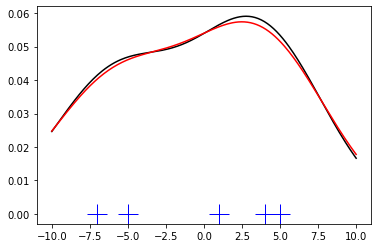

In [5]:
#Univariate estimation
import matplotlib.pyplot as plt
import numpy as np
x1 = np.array([-7, -5, 1, 4, 5], dtype=np.float)
kde1 = stats.gaussian_kde(x1)
kde2 = stats.gaussian_kde(x1, bw_method='silverman')

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x1, np.zeros(x1.shape), 'b+', ms=20)  # rug plot

x_eval = np.linspace(-10, 10, num=200)
ax.plot(x_eval, kde1(x_eval), 'k-', label="Scott's Rule")
ax.plot(x_eval, kde2(x_eval), 'r-', label="Silverman's Rule")

plt.show()

In [6]:
#kernel-density estimate using Gaussian kernels
#Kernel density estimation is a way to estimate the probability density function (PDF) of a random variable in a 
#non-parametric way. gaussian_kde works for both uni-variate and multi-variate data. 
#It includes automatic bandwidth determination. The estimation works best for a unimodal distribution; 
#bimodal or multi-modal distributions tend to be oversmoothed.

#Generate some random two-dimensional data:

from scipy import stats
def measure(n):
    "Measurement model, return two coupled measurements."
    m1 = np.random.normal(size=n)
    m2 = np.random.normal(scale=0.5, size=n)
    return m1+m2, m1-m2

m1, m2 = measure(2000)
xmin = m1.min()
xmax = m1.max()
ymin = m2.min()
ymax = m2.max()

In [7]:
#Perform a kernel density estimate on the data:

X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([m1, m2])
kernel = stats.gaussian_kde(values)
Z = np.reshape(kernel(positions).T, X.shape)

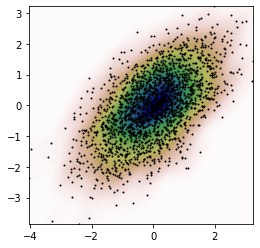

In [8]:
#Plot the results
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
          extent=[xmin, xmax, ymin, ymax])
ax.plot(m1, m2, 'k.', markersize=2)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
plt.show()